In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc, anndata as ad
import squidpy as sq
import matplotlib.colors as colors

In [15]:
# Load neuron and astrocyte average nuclear protein intensity matrices
neuron_df = pd.read_csv("./cell_measurements/neuron_nuclear_intensity_each_cell_all.csv")
astrocyte_df = pd.read_csv("./cell_measurements/astrocyte_nuclear_intensity_each_cell_all.csv")

# Read the Cell Type column
neuron_df["Cell Type"] = "Neuron"
astrocyte_df["Cell Type"] = "Astrocyte"

# Combine into one DataFrame
df = pd.concat([neuron_df, astrocyte_df], ignore_index=False)

# Identify protein intensity columns (excluding metadata)
metadata_cols = ["folder", "cell_number", "Cell Type"]
protein_cols = [col for col in df.columns if col not in metadata_cols]

# Normalize each protein intensity using 1st and 99th percentiles
normalized_df = df.copy()
for protein in protein_cols:
    p1 = np.percentile(df[protein], 1)
    p99 = np.percentile(df[protein], 99)
    normalized_df[protein] = (df[protein] - p1) / (p99 - p1)

# save normalized intensity file
# normalized_df.to_csv("./cell_measurements/normalized_protein_intensity.csv", index=False)


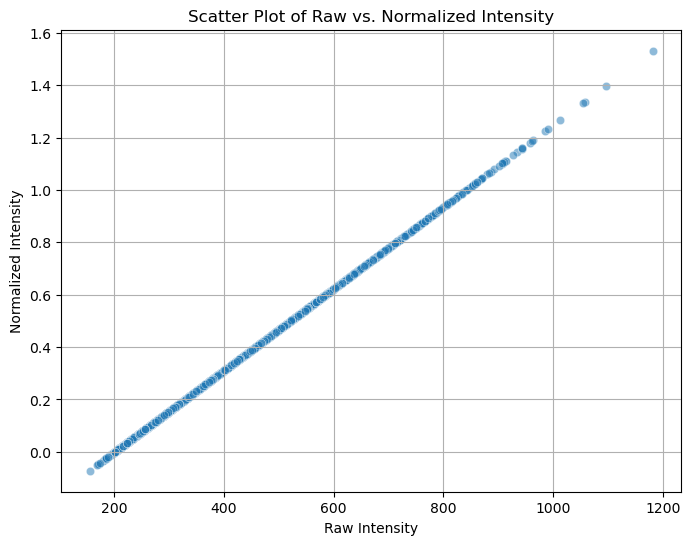

In [18]:
# Scatter plot of raw vs normalized intensity
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df["Fibrillarin"], y=normalized_df["Fibrillarin"], alpha=0.5)
plt.xlabel("Raw Intensity")
plt.ylabel("Normalized Intensity")
plt.title("Scatter Plot of Raw vs. Normalized Intensity")
plt.grid(True)
plt.show()

In [20]:
normalized_df

,folder,cell_number,SF3A66,Fibrillarin,H3K4me3,H3K27ac,HP1a,H3K27me3,CDK9,H2A_Z,H3K4me1,mH2A1,PolII,Matrin3,NPM1,DAPI,Cell Type
0,z0,122,0.441333,0.426309,0.851714,0.693039,0.567171,0.664753,0.550021,0.491559,0.455121,0.634703,0.532774,0.692364,0.386417,0.882682,Neuron
1,z0,124,0.384457,0.373055,0.709395,0.651113,0.556750,0.701009,0.387050,0.345246,0.602633,0.520553,0.445526,0.501403,0.284766,0.456410,Neuron
2,z0,132,0.732302,0.678980,0.723360,0.864674,0.919165,1.029450,0.795263,0.727824,0.729065,0.714704,0.689781,0.879316,0.623861,0.537394,Neuron
3,z0,134,0.389770,0.339294,0.730191,0.518331,0.305658,0.556545,0.430523,0.363035,0.508716,0.504439,0.448718,0.706477,0.406349,0.944496,Neuron
4,z0,144,0.273812,0.304390,0.924404,0.592590,0.481050,0.665270,0.414830,0.283952,0.677969,0.542650,0.392399,0.486725,0.276433,1.092207,Neuron
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2680,z40,95,0.092207,0.140495,0.156565,0.061423,0.038817,0.121741,0.096772,0.107903,0.129322,0.088066,0.100021,0.108542,0.051413,0.383442,Astrocyte
2681,z40,96,0.163805,0.257400,0.268266,0.173757,0.080845,0.138813,0.163518,0.182067,0.144133,0.153705,0.163771,0.123693,0.176870,0.552934,Astrocyte
2682,z40,97,0.215369,0.267854,0.326918,0.218865,0.113920,0.169716,0.265045,0.244975,0.212402,0.155227,0.244412,0.145500,0.258291,0.471435,Astrocyte
2683,z40,98,0.113735,0.231228,0.183070,0.110347,0.075433,0.183575,0.117784,0.105598,0.205332,0.154989,0.166390,0.092368,0.169938,0.310036,Astrocyte


In [22]:
# only use normalized nuclear protein intensity for clustering, excluding folder, cell number, and cell type columns

matrix_ad = ad.AnnData(X=normalized_df.iloc[:,2:-1])
matrix_ad

C:\Users\liany\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
C:\Users\liany\AppData\Local\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 4122 × 14

In [24]:
# Convert Cell Type column to a 1D array to add to anndata obseravation

cell_type = normalized_df[['Cell Type']]
cell_type_ar = cell_type.to_numpy()
cell_type_1d = cell_type_ar.ravel()
# print(cell_type_1d)
print(cell_type_1d.shape)

(4122,)


In [26]:
# Add ground truth cell type from NeuN and GFAP measurements to anndata as obs

matrix_ad.obs['cell_type']=pd.Categorical(cell_type_1d)
matrix_ad.obs['cell_type']

0          Neuron
1          Neuron
2          Neuron
3          Neuron
4          Neuron
          ...    
2680    Astrocyte
2681    Astrocyte
2682    Astrocyte
2683    Astrocyte
2684    Astrocyte
Name: cell_type, Length: 4122, dtype: category
Categories (2, object): ['Astrocyte', 'Neuron']

### Cluster using normalized nuclear protein intensity

In [29]:
print("PCA")
sc.tl.pca(matrix_ad, svd_solver="arpack")
print("neighbors")
sc.pp.neighbors(matrix_ad, n_neighbors=10) # n_pcs=10)

PCA
neighbors


In [30]:
print("UMAP")
sc.tl.umap(matrix_ad, min_dist=0) #,spread=0.5)

UMAP


In [31]:
print("Leiden")
resolution = 0.1
sc.tl.leiden(matrix_ad, resolution=resolution)

Leiden


C:\Users\liany\AppData\Local\Temp\ipykernel_71352\1795512296.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(matrix_ad, resolution=resolution)


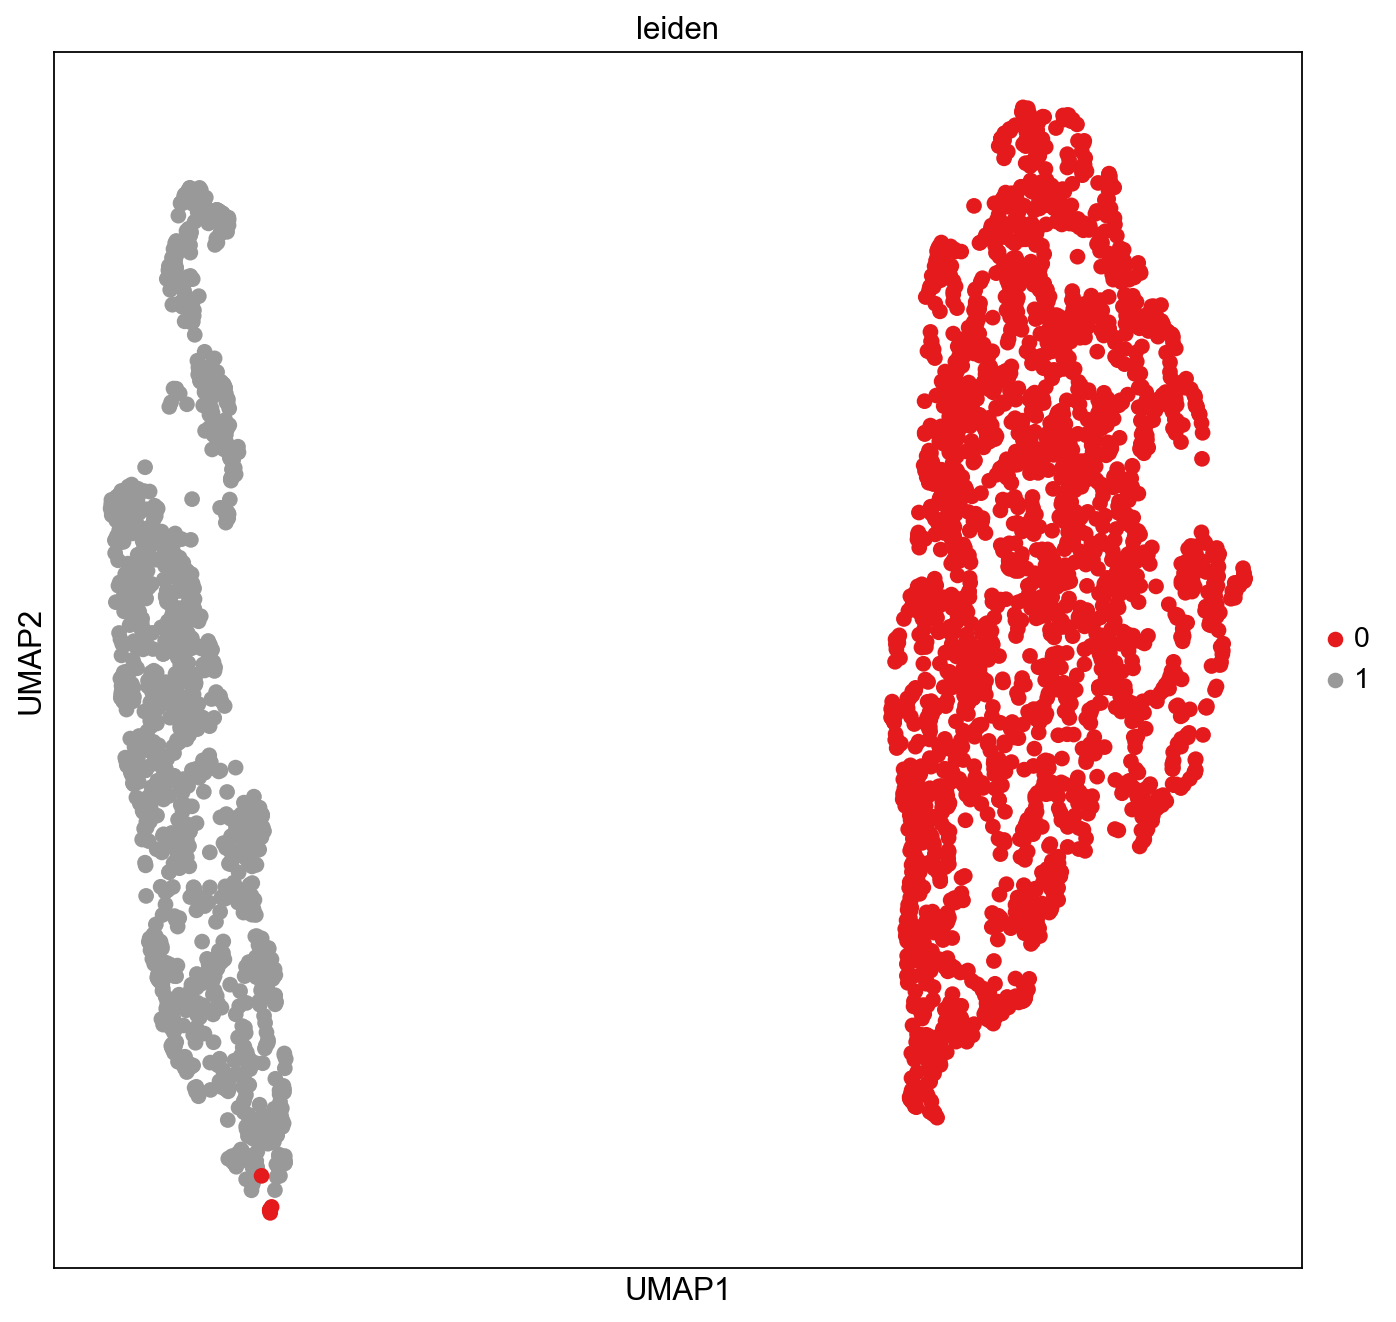

In [32]:
# UMAP clustering using nuclear protein intensities

sc.set_figure_params(figsize=(10, 10))
sc.pl.umap(matrix_ad, color=["leiden"], size=200, palette = "Set1", save='umap_clusters_rela_int_12Ab.png')

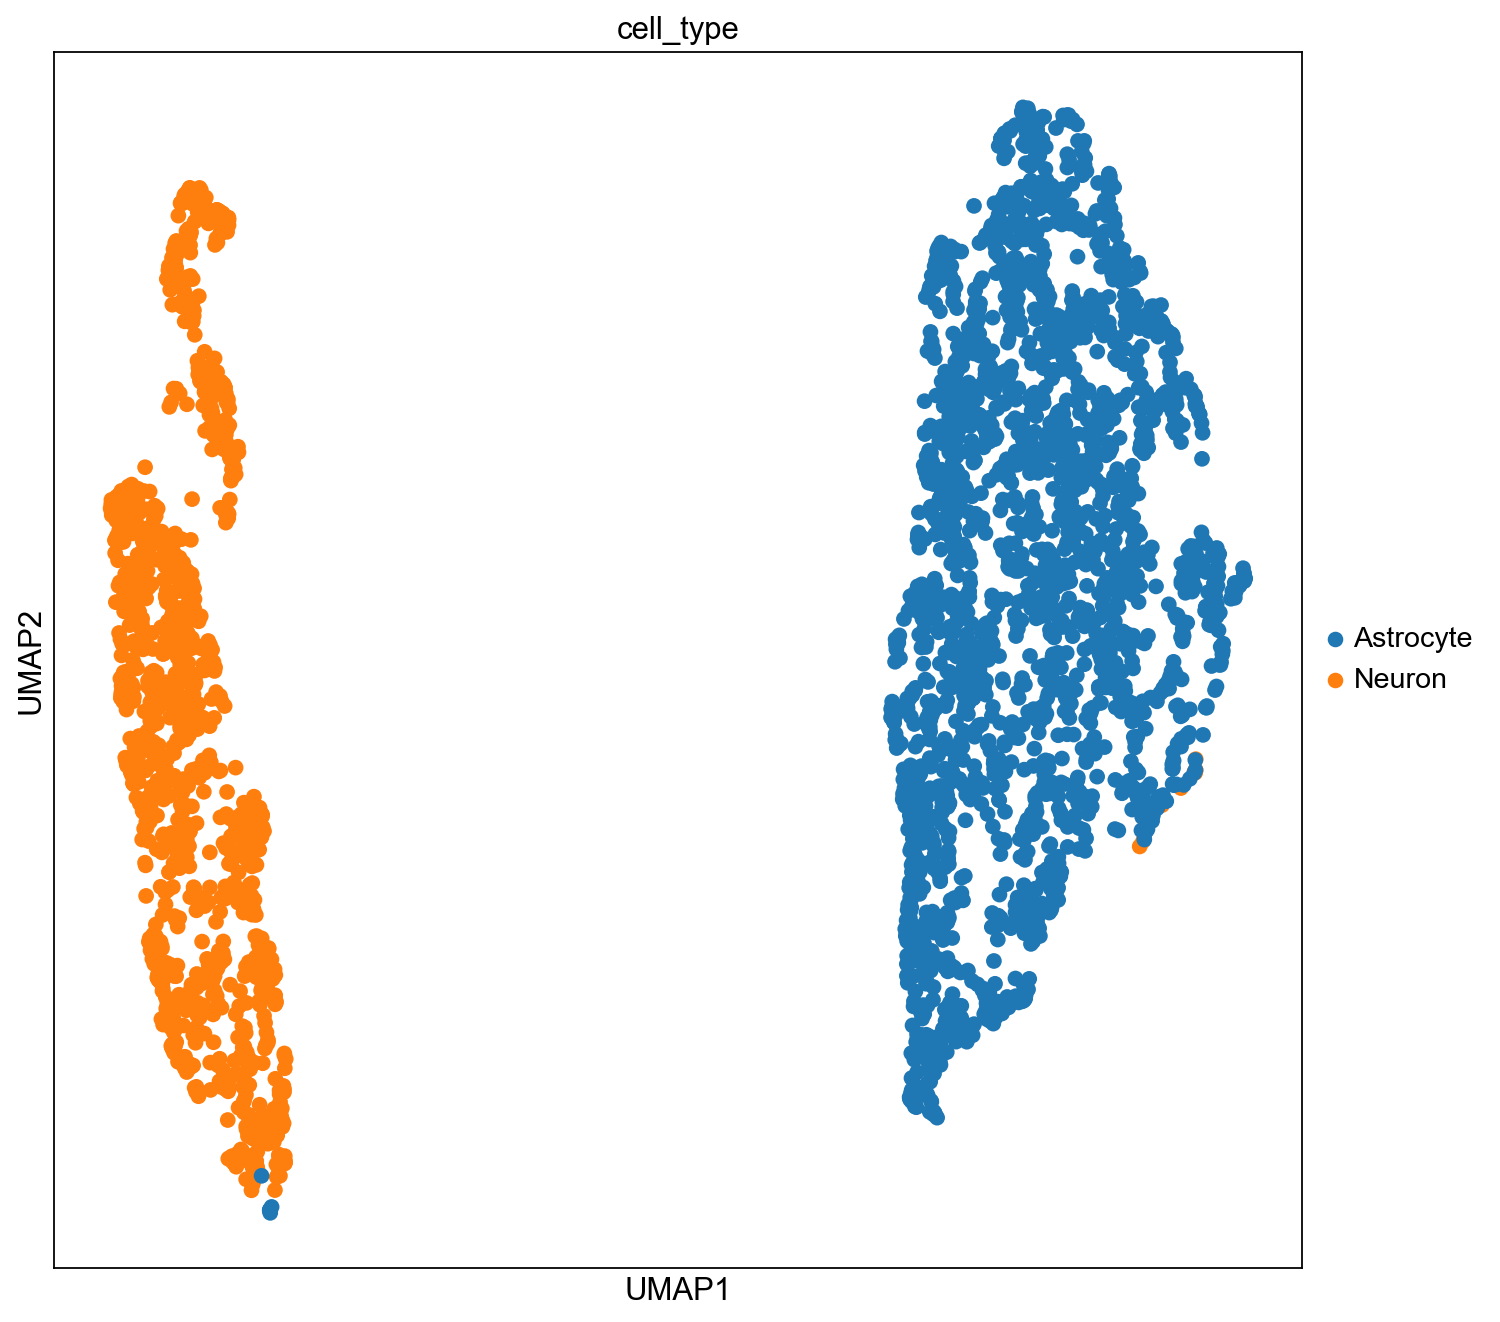

In [33]:
# UMAP visualized by showing cells colored by their ground-truth cell type labels

sc.pl.umap(matrix_ad, color=["cell_type"], size=200, save='umap_N_A_rela_int_12Ab.png')

## Calculate confusion matrix for UMAP classification 

In [35]:
# Numbers of neurons and astrocytes in cluster 0
cluster0 = matrix_ad[matrix_ad.obs.leiden == '0']
cluster0.obs["cell_type"].value_counts()

cell_type
Astrocyte    2685
Neuron         12
Name: count, dtype: int64

In [26]:
# Numbers of neurons and astrocytes in cluster 1
cluster1 = matrix_ad[matrix_ad.obs.leiden == '1']
cluster1.obs["cell_type"].value_counts()

cell_type
Neuron    1425
Name: count, dtype: int64

In [42]:
print("Astrocytes correctly in cluster 1:", 2685/2685)
print("Astrocytes incorrectly in Cluster 2:", 0/2685)

Astrocytes correctly in cluster 1: 1.0
Astrocytes incorrectly in Cluster 2: 0.0


In [44]:
print("Neurons incorrectly in Cluster 1:", 12/(1425+12))
print("Neurons correctly in Cluster 2:", 1425/(1425+12))

Neurons incorrectly in Cluster 1: 0.008350730688935281
Neurons correctly in Cluster 2: 0.9916492693110647
